In [1]:
import os
import platform
import time
import itertools
import glob as glob 

import numpy as np
import pandas as pd
import seaborn as sns
import cv2 as cv
import matplotlib.pyplot as plt

from PIL import Image

from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay, average_precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax, AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import regularizers, Input, Model

In [2]:
DATA_DIR = 'testing'
CSV_PATH = 'testing/labels_updated.csv' 

EXPERIMENT_PATH = 'experiment'

BATCH_SIZE = 48
EPOCHS = 5
LEARNING_RATE = 15e-4

IMAGE_SIZE = (256, 256)
CHANNELS = 3
INPUT_SHAPE = IMAGE_SIZE + (CHANNELS,)


In [3]:
df = pd.read_csv(CSV_PATH)
df

,image_name,label,split,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pneumonia,Pneumothorax
0,s56413889.jpg,No Finding,train,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,s55767224.jpg,No Finding,train,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,s57125979.jpg,Cardiomegaly,train,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,s54729332.jpg,"Atelectasis,Enlarged Cardiomediastinum,Lung Op...",train,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,s58317325.jpg,"Lung Opacity,Pneumothorax",train,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17669,s57963258.jpg,"Edema,Pleural Effusion,Pneumothorax",test,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
17670,s55694572.jpg,"Atelectasis,Cardiomegaly,Consolidation,Edema,L...",test,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
17671,s53308763.jpg,No Finding,test,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
17672,s53331453.jpg,"Edema,Pleural Effusion",test,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [4]:
train_df = df[df['split'] == 'train']  # Filter for train split
val_df = df[df['split'] == 'valid']   # Filter for valid split
test_df = df[df['split'] == 'test']

print(f'Number of total images:\ntrain={len(train_df)}, val={len(val_df)}, test={len(test_df)}')

Number of total images:
train=14139, val=1767, test=1768


In [5]:
import os
import glob
import numpy as np
import pandas as pd
import cv2 as cv
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing import image as tf_image


class PreProcessSequence(tf.keras.utils.Sequence):
    def __init__(self, df, input_folder, batch_size=48):
    
        self.df = df
        self.input_folder = input_folder
        self.batch_size = batch_size
        

        
        self.train_df = self.df[self.df['split'] == 'train']
        self.valid_df = self.df[self.df['split'] == 'valid']
        self.test_df = self.df[self.df['split'] == 'test']
        
        self.imagenet_mean = np.array([0.485, 0.456, 0.406])  
        self.imagenet_std = np.array([0.229, 0.224, 0.225])

        #self.unique_labels = [
        #    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum',
        #    'Lung Lesion', 'Lung Opacity', 'Normal', 'Pleural Effusion', 'Pneumonia', 'Pneumothorax'
        #]
        self.unique_labels = [
            'Atelectasis','Cardiomegaly','Consolidation','Edema','Enlarged Cardiomediastinum','Fracture','Lung Lesion','Lung Opacity','No Finding','Pleural Effusion','Pneumonia','Pneumothorax'
        ]
    
    def normalize_imagenet(self,image: np.ndarray):
        image = (image - image.min()) / (image.max() - image.min()) #[0,1]

        image = (image-self.imagenet_mean) / self.imagenet_std

        return image
    
    def preprocess(self, image):
        image = np.array(image)
        r_image = cv.resize(image, (256, 256))
        r_image=self.normalize_imagenet(r_image)
        r_image=tf.image.random_flip_left_right(r_image)
        r_image=tf.image.central_crop(r_image,central_fraction=224/256)
        r_image=tf.keras.preprocessing.image.random_rotation(r_image,15)




       

        return r_image
    
    
    
  

    def __len__(self):
        
        return np.ceil(len(self.df) / self.batch_size).astype(int)


    def __getitem__(self, index):
        """Generates one batch of data."""
        # Get the batch of samples
        batch = self.df[index * self.batch_size : (index + 1) * self.batch_size]
    
        images = []
        labels = []
        for filename, label in zip(batch['image_name'], batch[self.unique_labels].values):
            
            split = batch['split'].iloc[0]
            path = os.path.join(self.input_folder, split, filename)

            image=Image.open(path)
            
            image = self.preprocess(image)
            images.append(image)
        
            
            labels.append(np.array(label))  
    
        # Convert the images to a numpy array
        images = np.array(images,dtype=np.float32)

        # Cast images to float32 for TensorFlow
        #images = tf.cast(images, dtype=tf.float32)
        

         
        return images, np.array(labels,dtype=np.float32)
    
       
    
    def get_dataframe_for_split(self, split='train'):
        """Returns the filtered dataframe for the given split."""
        if split == 'train':
            return self.train_df
        elif split == 'valid':
            return self.valid_df
        elif split == 'test':
            return self.test_df
        else:
            raise ValueError("Split must be one of 'train', 'valid', or 'test'")

In [6]:
unique_labels_big = [
            'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum',
            'Lung Lesion', 'Lung Opacity', 'Normal', 'Pleural Effusion', 'Pneumonia', 'Pneumothorax'
        ]

unique_labels_small = [
    "Atelectasis","Cardiomegaly","Consolidation","Edema","Enlarged Cardiomediastinum","Fracture","Lung Lesion","Lung Opacity","No Finding","Pleural Effusion","Pneumonia","Pneumothorax"
]

NUM_LABELS=len(unique_labels_small)
NUM_LABELS


12

In [7]:

train_gen = PreProcessSequence(train_df, DATA_DIR, batch_size=BATCH_SIZE)
val_gen = PreProcessSequence(val_df, DATA_DIR, batch_size=BATCH_SIZE)
test_gen = PreProcessSequence(test_df, DATA_DIR, batch_size=BATCH_SIZE)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
from tqdm import tqdm 
import copy 
from sklearn.metrics import roc_auc_score, f1_score

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda:0


In [ ]:
class DenseNet121(nn.Module):
    def __init__(self, num_classes, dropout_rate1=0.3, dropout_rate2=0.5, hidden_units=256):
        super().__init__()
        # Load pre-trained DenseNet121
        self.densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

        # Get the number of features from the original classifier
        num_features = self.densenet.classifier.in_features 

        # Replace the classifier with our custom head
        
        self.densenet.classifier = nn.Identity() # Remove the final layer

        # Custom head
        self.dropout1 = nn.Dropout(dropout_rate1)
        self.fc1 = nn.Linear(num_features, hidden_units)
        self.sigmoid1 = nn.Sigmoid() 
        self.dropout2 = nn.Dropout(dropout_rate2)
        self.fc2 = nn.Linear(hidden_units, num_classes)
        

    def forward(self, x):
        
        features = self.densenet(x)
       

        out = self.dropout1(features)
        out = self.fc1(out)
        out = self.sigmoid1(out) 
        out = self.dropout2(out)
        out = self.fc2(out) 
        return out



Using device: cuda


In [ ]:
model = DenseNet121(num_classes=NUM_LABELS)
model.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

model_name = 'DenseNet121' 
EXPERIMENT_ID = f'{model_name}--TL--lr_{LEARNING_RATE}--batch_size_{BATCH_SIZE}--epochs_{EPOCHS}--pytorch'
EXPERIMENT_SAVE_PATH = os.path.join(EXPERIMENT_PATH, EXPERIMENT_ID)

if not os.path.isdir(EXPERIMENT_SAVE_PATH):
    os.makedirs(EXPERIMENT_SAVE_PATH)
else:
    print('Directory  already exists!')

# Create subdirectories using exist_ok=True for simplicity
REPORTS_SAVE_PATH = os.path.join(EXPERIMENT_SAVE_PATH, 'reports')
MODEL_SAVE_PATH = os.path.join(EXPERIMENT_SAVE_PATH, 'model')
os.makedirs(REPORTS_SAVE_PATH, exist_ok=True)
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)


best_loss_weight_path = os.path.join(MODEL_SAVE_PATH, f'{model_name}--best_loss_weights.pth')
best_f1_weight_path = os.path.join(MODEL_SAVE_PATH, f'{model_name}--best_val_f1_weights.pth')

Directory  already exists!


In [ ]:
best_val_loss = float('inf')
best_val_f1 = 0.0
early_stopping_patience = 10
early_stopping_counter = 0

best_model_wts_f1 = copy.deepcopy(model.state_dict())


history = {'train_loss': [], 'train_auc': [], 'val_loss': [], 'val_f1': []}



In [ ]:
print("Starting Training...")

for epoch in range(EPOCHS):
    print(f'\nEpoch {epoch+1}/{EPOCHS}')
   
    model.train()

    running_loss = 0.0
    
    train_all_outputs = []
    train_all_labels = []
    total_samples_train = 0

    
    train_pbar = tqdm(range(len(train_gen)), desc="Training")

    for i in train_pbar:
    
        images_tf_np, labels_np = train_gen[i]

    
        images = torch.from_numpy(images_tf_np).permute(0, 3, 1, 2).to(device)
        labels = torch.from_numpy(labels_np).to(device)

        
        optimizer.zero_grad()

        
        outputs = model(images)
        loss = criterion(outputs, labels)

        
        train_all_outputs.append(torch.sigmoid(outputs).detach().cpu().numpy())
        train_all_labels.append(labels.detach().cpu().numpy())
        

        
        loss.backward()
        optimizer.step()

        preds = torch.sigmoid(outputs) > 0.5
        corrects = torch.sum(preds == labels.byte()).item() 
        
        batch_acc = corrects / (labels.size(0) * labels.size(1))
        running_loss += loss.item() * images.size(0)
        
        total_samples_train += labels.size(0) 

        
        train_pbar.set_postfix({'loss': loss.item(), 'Acc': batch_acc})

    epoch_train_loss = running_loss / total_samples_train
    history['train_loss'].append(epoch_train_loss)

    train_all_outputs = np.concatenate(train_all_outputs, axis=0)
    train_all_labels = np.concatenate(train_all_labels, axis=0)
    epoch_train_auc = roc_auc_score(train_all_labels, train_all_outputs, average='macro')
    history['train_auc'].append(epoch_train_auc)





    

    print(f'Train Loss: {epoch_train_loss:.4f} AUC: {epoch_train_auc:.4f}')

    
    model.eval() 
    running_loss = 0.0
    val_all_outputs = []
    val_all_labels = []
    total_samples_val = 0

    val_pbar = tqdm(range(len(val_gen)), desc="Validation")

    with torch.no_grad(): 
        for i in val_pbar:
            images_tf_np, labels_np = val_gen[i]

            
            images = torch.from_numpy(images_tf_np).permute(0, 3, 1, 2).to(device)
            labels = torch.from_numpy(labels_np).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            preds = torch.sigmoid(outputs) > 0.5
            corrects = torch.sum(preds == labels.byte()).item()
            batch_acc = corrects / (labels.size(0) * labels.size(1))

            running_loss += loss.item() * images.size(0)
            running_corrects += corrects
            total_samples_val += labels.size(0)

            val_all_outputs.append(torch.sigmoid(outputs).detach().cpu().numpy())
            val_all_labels.append(labels.detach().cpu().numpy())

            val_pbar.set_postfix({'loss': loss.item(), 'acc': batch_acc})


    epoch_val_loss = running_loss / total_samples_val
    history['val_loss'].append(epoch_val_loss)

    val_all_outputs = np.concatenate(val_all_outputs, axis=0)
    val_all_labels = np.concatenate(val_all_labels, axis=0)
    val_preds_binary = (val_all_outputs > 0.5).astype(int)
    epoch_val_f1 = f1_score(val_all_labels, val_preds_binary, average='macro', zero_division=0)


    history['val_f1'].append(epoch_val_f1)
    print(f'Val Loss: {epoch_val_loss:.4f} Val F1: {epoch_val_f1:.4f}')

    
    scheduler.step(epoch_val_loss)

    
    if epoch_val_f1 > best_val_f1:                         
        print(f"Validation F1 improved ({best_val_f1:.4f} -> {epoch_val_f1:.4f}). Saving best F1 model weights")
        best_val_f1 = epoch_val_f1                          
        best_model_wts_f1 = copy.deepcopy(model.state_dict()) 
        torch.save(best_model_wts_f1, best_f1_weight_path)


    
    if early_stopping_counter >= early_stopping_patience:
        print(f"Early stopping triggered after {early_stopping_patience} epochs without improvement.")
        break 


print('Training finished.')

Starting Training...

Epoch 1/5


Training: 100%|██████████| 295/295 [10:38<00:00,  2.16s/it, loss=0.411, Acc=0.815]


Train Loss: 0.4232 AUC: 0.5875


Validation: 100%|██████████| 37/37 [01:06<00:00,  1.80s/it, loss=0.379, acc=0.835]


Val Loss: 0.4003 Val F1: 0.1678
Validation F1 improved (0.0000 -> 0.1678). Saving best F1 model weights

Epoch 2/5


Training: 100%|██████████| 295/295 [14:30<00:00,  2.95s/it, loss=0.414, Acc=0.802]


Train Loss: 0.4009 AUC: 0.6402


Validation: 100%|██████████| 37/37 [01:06<00:00,  1.81s/it, loss=0.39, acc=0.833] 


Val Loss: 0.4024 Val F1: 0.1573

Epoch 3/5


Training: 100%|██████████| 295/295 [13:51<00:00,  2.82s/it, loss=0.397, Acc=0.812]


Train Loss: 0.3945 AUC: 0.6600


Validation: 100%|██████████| 37/37 [01:09<00:00,  1.88s/it, loss=0.371, acc=0.829]


Val Loss: 0.4001 Val F1: 0.2011
Validation F1 improved (0.1678 -> 0.2011). Saving best F1 model weights

Epoch 4/5


Training: 100%|██████████| 295/295 [13:54<00:00,  2.83s/it, loss=0.39, Acc=0.815] 


Train Loss: 0.3905 AUC: 0.6697


Validation: 100%|██████████| 37/37 [01:12<00:00,  1.97s/it, loss=0.369, acc=0.838]


Val Loss: 0.3964 Val F1: 0.2089
Validation F1 improved (0.2011 -> 0.2089). Saving best F1 model weights

Epoch 5/5


Training: 100%|██████████| 295/295 [10:49<00:00,  2.20s/it, loss=0.388, Acc=0.827]


Train Loss: 0.3871 AUC: 0.6805


Validation: 100%|██████████| 37/37 [01:09<00:00,  1.87s/it, loss=0.364, acc=0.844]

Val Loss: 0.3939 Val F1: 0.2087
Training finished.


In [ ]:
final_model_wts_f1=copy.deepcopy(model.state_dict)
torch.save(final_model_wts_f1, best_f1_weight_path)



In [ ]:
model.eval()
test_all_outputs = []
test_all_labels = []

print("\nStarting Evaluation on Test Set")
test_pbar = tqdm(range(len(test_gen)), desc="Testing")

with torch.no_grad(): 
    for i in test_pbar:
        
        
        images_np, labels_np = test_gen[i]

        # Skip empty batches if any occurred due to file errors
        if images_np.size == 0 or labels_np.size == 0:
                print(f"Skipping empty batch index {i}")
                continue

        
        images = torch.from_numpy(images_np).permute(0, 3, 1, 2).to(device)
        labels = torch.from_numpy(labels_np).to(device)

        
        outputs = model(images)

        
        probabilities = torch.sigmoid(outputs)

        
        test_all_outputs.append(probabilities.detach().cpu().numpy())
        test_all_labels.append(labels.detach().cpu().numpy())

       


test_all_outputs = np.concatenate(test_all_outputs, axis=0)
test_all_labels = np.concatenate(test_all_labels, axis=0)

test_auc_macro = roc_auc_score(test_all_labels, test_all_outputs, average='macro')
print(f"\nTest Set AUC (Macro): {test_auc_macro:.4f}")



Starting Evaluation on Test Set


Testing: 100%|██████████| 37/37 [01:16<00:00,  2.08s/it]


Test Set AUC (Macro): 0.6786


In [ ]:
num_classes = test_all_labels.shape[1]
per_class_auc = {}

print("\n--- Test Set AUC per Class ---")

for i in range(num_classes):
    class_name = unique_labels_small[i]
    y_true_class = test_all_labels[:, i]   
    y_score_class = test_all_outputs[:, i] 

   
    if len(np.unique(y_true_class)) < 2:
        print(f"  - {class_name}: AUC cannot be calculated (only one class present in labels)")
        per_class_auc[class_name] = np.nan # Assign NaN or skip
    else:
        try:
            auc_score = roc_auc_score(y_true_class, y_score_class)
            per_class_auc[class_name] = auc_score
            print(f"  - {class_name}: {auc_score:.4f}")
        except ValueError as e:
                # Catch any other potential issues, though the check above handles the main one
                print(f"  - {class_name}: Error calculating AUC - {e}")
                per_class_auc[class_name] = np.nan

   


--- Test Set AUC per Class ---
  - Atelectasis: 0.6909
------------------------------
  - Cardiomegaly: 0.6910
------------------------------
  - Consolidation: 0.6780
------------------------------
  - Edema: 0.7877
------------------------------
  - Enlarged Cardiomediastinum: 0.5407
------------------------------
  - Fracture: 0.5748
------------------------------
  - Lung Lesion: 0.6115
------------------------------
  - Lung Opacity: 0.6486
------------------------------
  - No Finding: 0.7576
------------------------------
  - Pleural Effusion: 0.8152
------------------------------
  - Pneumonia: 0.6378
------------------------------
  - Pneumothorax: 0.7094
------------------------------


In [37]:
test_preds_binary = (test_all_outputs > 0.5).astype(int)
test_f1_macro = f1_score(test_all_labels, test_preds_binary, average='macro', zero_division=0)
print(f"Test Set F1 Score (Macro): {test_f1_macro:.4f}")

Test Set F1 Score (Macro): 0.2095


In [38]:
correct_predictions = np.sum(test_preds_binary == test_all_labels)
total_predictions = test_all_labels.size 
test_accuracy = correct_predictions / total_predictions
print(f"Test Set Accuracy: {test_accuracy:.4f}")

Test Set Accuracy: 0.8199


In [ ]:
print("\nClassification Report (Test Set):")

print(classification_report(test_all_labels, test_preds_binary, target_names=unique_labels_small))




Classification Report (Test Set):
                            precision    recall  f1-score   support

               Atelectasis       0.57      0.19      0.28       616
              Cardiomegaly       0.47      0.53      0.50       563
             Consolidation       0.00      0.00      0.00       172
                     Edema       0.51      0.60      0.55       463
Enlarged Cardiomediastinum       0.00      0.00      0.00       197
                  Fracture       0.00      0.00      0.00        26
               Lung Lesion       0.00      0.00      0.00        41
              Lung Opacity       0.51      0.14      0.22       558
                No Finding       0.60      0.23      0.33       313
          Pleural Effusion       0.69      0.58      0.63       682
                 Pneumonia       0.00      0.00      0.00       282
              Pneumothorax       0.00      0.00      0.00       148

                 micro avg       0.55      0.30      0.39      4061
           

c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


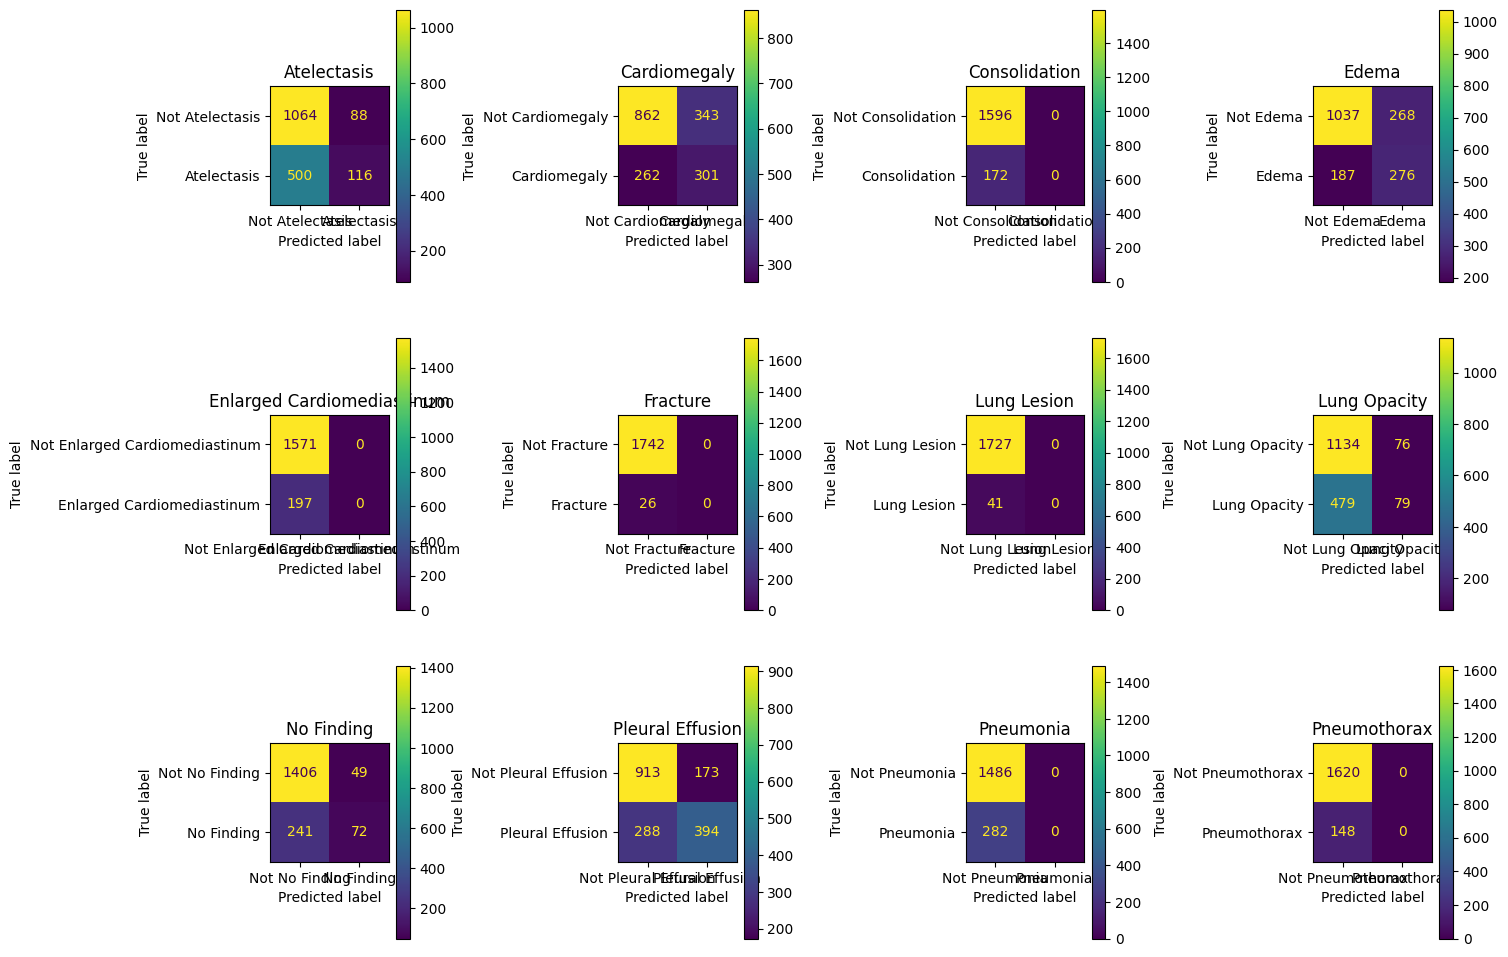

In [ ]:
M_cm = multilabel_confusion_matrix(test_all_labels, test_preds_binary)
fig, axes = plt.subplots(3, 4, figsize=(15, 10))  
axes = axes.ravel()
for i, label in enumerate(unique_labels_small):
    if i < len(axes):  
        display = ConfusionMatrixDisplay(confusion_matrix=M_cm[i], display_labels=[f'Not {label}', label])
        display.plot(ax=axes[i], values_format='d')
        axes[i].set_title(label)
plt.tight_layout()
plt.show()




In [41]:
history

{'train_loss': [0.42317359846614105,
  0.40093895771461463,
  0.39452314072674105,
  0.3905483145838251,
  0.38714754955166086],
 'train_auc': [0.5874811417634237,
  0.6402285168681651,
  0.6599884328329675,
  0.6697195432099713,
  0.6804620343428746],
 'val_loss': [0.400346025293266,
  0.4023548147067149,
  0.40010292744596054,
  0.3964484203448725,
  0.3939128192758317],
 'val_f1': [0.16775549043439555,
  0.1573010578327763,
  0.20112957250695676,
  0.20887678426582088,
  0.2086578215408936]}

Loss plot saved to experiment\DenseNet121--TL--lr_0.0005--batch_size_48--epochs_5--pytorch\reports\DenseNet121--loss_plot.png


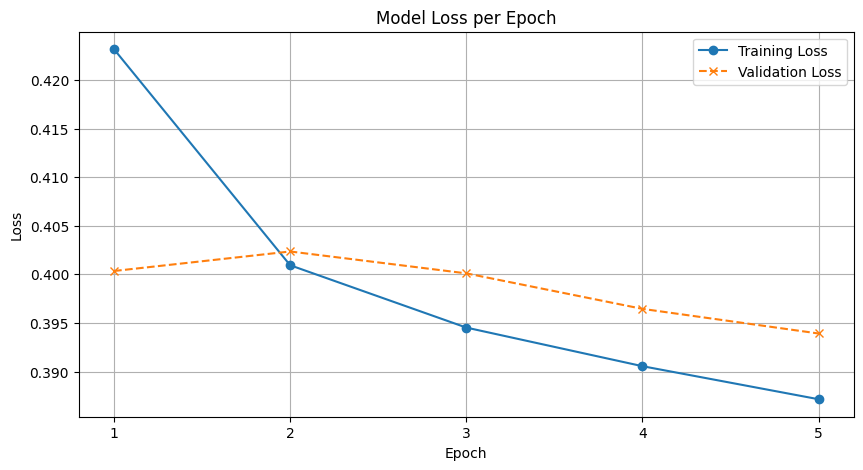

AUC/F1 plot saved to experiment\DenseNet121--TL--lr_0.0005--batch_size_48--epochs_5--pytorch\reports\DenseNet121--auc_f1_plot.png


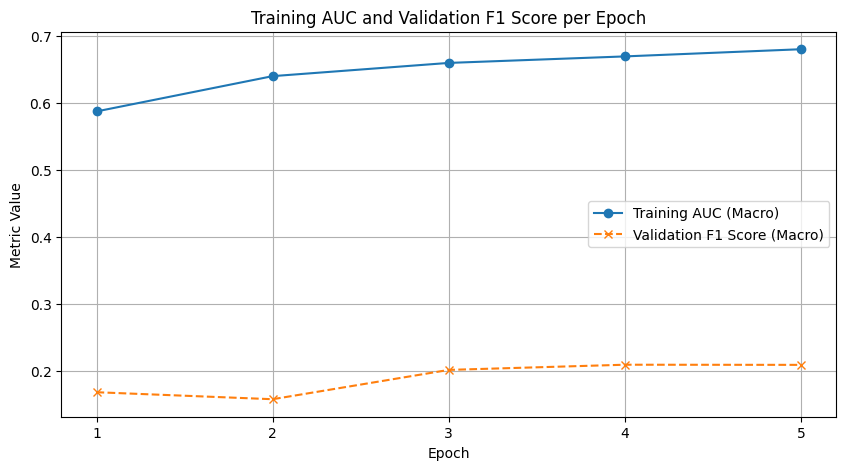

In [ ]:
epochs_completed = len(history['train_loss'])
epochs_range = range(1, epochs_completed + 1)


plt.figure(figsize=(10, 5))
plt.plot(epochs_range, history['train_loss'], label='Training Loss', marker='o', linestyle='-')

if 'val_loss' in history and len(history['val_loss']) == epochs_completed:
        plt.plot(epochs_range, history['val_loss'], label='Validation Loss', marker='x', linestyle='--')
else:
    print("Warning: Validation loss data not found or length mismatch, skipping plot.")

plt.title('Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.xticks(epochs_range) 


loss_plot_path = os.path.join(REPORTS_SAVE_PATH, f'{model_name}--loss_plot.png')
plt.savefig(loss_plot_path)
print(f"Loss plot saved to {loss_plot_path}")
plt.show() 



plt.figure(figsize=(10, 5))
plt.plot(epochs_range, history['train_auc'], label='Training AUC (Macro)', marker='o', linestyle='-')

if 'val_f1' in history and len(history['val_f1']) == epochs_completed:
    plt.plot(epochs_range, history['val_f1'], label='Validation F1 Score (Macro)', marker='x', linestyle='--')
else:
    print("Warning: Validation F1 score data not found or length mismatch, skipping plot.")

plt.title('Training AUC and Validation F1 Score per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')

plt.legend()
plt.grid(True)
plt.xticks(epochs_range) 


metrics_plot_path = os.path.join(REPORTS_SAVE_PATH, f'{model_name}--auc_f1_plot.png')
plt.savefig(metrics_plot_path)
print(f"AUC/F1 plot saved to {metrics_plot_path}")
plt.show() 

#AlexNet

In [15]:
class AlexNetModel(nn.Module):
    def __init__(self, num_classes, dropout_rate1=0.3, dropout_rate2=0.5, hidden_units=256):
        super().__init__()
        
        self.alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

       
        num_features_pre_classifier = 256 * 6 * 6

        
        self.features = self.alexnet.features
        self.avgpool = self.alexnet.avgpool 

       
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate1), #
            nn.Linear(num_features_pre_classifier, hidden_units),
            nn.ReLU(), 
            nn.Dropout(p=dropout_rate2), 
            nn.Linear(hidden_units, num_classes),
           
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1) 
        x = self.classifier(x) 
        return x

In [ ]:
model = AlexNetModel(num_classes=NUM_LABELS)
model.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

model_name = 'AlexNet' 
EXPERIMENT_ID = f'{model_name}--TL--lr_{LEARNING_RATE}--batch_size_{BATCH_SIZE}--epochs_{EPOCHS}--pytorch'
EXPERIMENT_SAVE_PATH = os.path.join(EXPERIMENT_PATH, EXPERIMENT_ID)

if not os.path.isdir(EXPERIMENT_SAVE_PATH):
    os.makedirs(EXPERIMENT_SAVE_PATH)
else:
    print('Directory  already exists!')


REPORTS_SAVE_PATH = os.path.join(EXPERIMENT_SAVE_PATH, 'reports')
MODEL_SAVE_PATH = os.path.join(EXPERIMENT_SAVE_PATH, 'model')
os.makedirs(REPORTS_SAVE_PATH, exist_ok=True)
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)


best_loss_weight_path = os.path.join(MODEL_SAVE_PATH, f'{model_name}--best_loss_weights.pth')
best_f1_weight_path = os.path.join(MODEL_SAVE_PATH, f'{model_name}--best_val_f1_weights.pth')

Directory  already exists!


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
best_val_loss = float('inf')
best_val_f1 = 0.0
early_stopping_patience = 10
early_stopping_counter = 0

best_model_wts_f1 = copy.deepcopy(model.state_dict())


history = {'train_loss': [], 'train_auc': [], 'val_loss': [], 'val_f1': []}


print("Starting Training...")

for epoch in range(EPOCHS):
    print(f'\nEpoch {epoch+1}/{EPOCHS}')
   
    model.train()

    running_loss = 0.0
    
    train_all_outputs = []
    train_all_labels = []
    total_samples_train = 0

    
    train_pbar = tqdm(range(len(train_gen)), desc="Training")

    for i in train_pbar:
    
        images_tf_np, labels_np = train_gen[i]

    
        images = torch.from_numpy(images_tf_np).permute(0, 3, 1, 2).to(device)
        labels = torch.from_numpy(labels_np).to(device)

        
        optimizer.zero_grad()

        
        outputs = model(images)
        loss = criterion(outputs, labels)

        
        train_all_outputs.append(torch.sigmoid(outputs).detach().cpu().numpy())
        train_all_labels.append(labels.detach().cpu().numpy())
        

        
        loss.backward()
        optimizer.step()

        preds = torch.sigmoid(outputs) > 0.5
        corrects = torch.sum(preds == labels.byte()).item() 
        batch_acc = corrects / (labels.size(0) * labels.size(1))
        running_loss += loss.item() * images.size(0)
        
        total_samples_train += labels.size(0) 

        
        train_pbar.set_postfix({'loss': loss.item(), 'Acc': batch_acc})

    epoch_train_loss = running_loss / total_samples_train
    history['train_loss'].append(epoch_train_loss)

    train_all_outputs = np.concatenate(train_all_outputs, axis=0)
    train_all_labels = np.concatenate(train_all_labels, axis=0)
    epoch_train_auc = roc_auc_score(train_all_labels, train_all_outputs, average='macro')
    history['train_auc'].append(epoch_train_auc)





    

    print(f'Train Loss: {epoch_train_loss:.4f} AUC: {epoch_train_auc:.4f}')

    
    model.eval() 
    running_loss = 0.0
    val_all_outputs = []
    val_all_labels = []
    total_samples_val = 0

    val_pbar = tqdm(range(len(val_gen)), desc="Validation")

    with torch.no_grad(): 
        for i in val_pbar:
            images_tf_np, labels_np = val_gen[i]

            
            images = torch.from_numpy(images_tf_np).permute(0, 3, 1, 2).to(device)
            labels = torch.from_numpy(labels_np).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            preds = torch.sigmoid(outputs) > 0.5
            corrects = torch.sum(preds == labels.byte()).item()
            batch_acc = corrects / (labels.size(0) * labels.size(1))

            running_loss += loss.item() * images.size(0)
            #running_corrects += corrects
            total_samples_val += labels.size(0)

            val_all_outputs.append(torch.sigmoid(outputs).detach().cpu().numpy())
            val_all_labels.append(labels.detach().cpu().numpy())

            val_pbar.set_postfix({'loss': loss.item(), 'acc': batch_acc})


    epoch_val_loss = running_loss / total_samples_val
    history['val_loss'].append(epoch_val_loss)

    val_all_outputs = np.concatenate(val_all_outputs, axis=0)
    val_all_labels = np.concatenate(val_all_labels, axis=0)
    val_preds_binary = (val_all_outputs > 0.5).astype(int)
    epoch_val_f1 = f1_score(val_all_labels, val_preds_binary, average='macro', zero_division=0)


    history['val_f1'].append(epoch_val_f1)
    print(f'Val Loss: {epoch_val_loss:.4f} Val F1: {epoch_val_f1:.4f}')

    
    scheduler.step(epoch_val_loss)

    
    if epoch_val_f1 > best_val_f1:                         
        print(f"Validation F1 improved ({best_val_f1:.4f} -> {epoch_val_f1:.4f}). Saving best F1 model weights")
        best_val_f1 = epoch_val_f1                          
        best_model_wts_f1 = copy.deepcopy(model.state_dict()) 
        torch.save(best_model_wts_f1, best_f1_weight_path)


    
    if early_stopping_counter >= early_stopping_patience:
        print(f"Early stopping triggered after {early_stopping_patience} epochs without improvement.")
        break 


print('Training finished.')

Starting Training...

Epoch 1/5


Training: 100%|██████████| 295/295 [11:04<00:00,  2.25s/it, loss=0.419, Acc=0.793]


Train Loss: 0.4422 AUC: 0.5314


Validation: 100%|██████████| 37/37 [02:23<00:00,  3.88s/it, loss=0.398, acc=0.829]


Val Loss: 0.4178 Val F1: 0.0233
Validation F1 improved (0.0000 -> 0.0233). Saving best F1 model weights

Epoch 2/5


Training: 100%|██████████| 295/295 [12:38<00:00,  2.57s/it, loss=0.413, Acc=0.806]


Train Loss: 0.4243 AUC: 0.5795


Validation: 100%|██████████| 37/37 [01:06<00:00,  1.79s/it, loss=0.401, acc=0.827]


Val Loss: 0.4151 Val F1: 0.0453
Validation F1 improved (0.0233 -> 0.0453). Saving best F1 model weights

Epoch 3/5


Training: 100%|██████████| 295/295 [09:06<00:00,  1.85s/it, loss=0.405, Acc=0.809]


Train Loss: 0.4218 AUC: 0.5835


Validation: 100%|██████████| 37/37 [01:06<00:00,  1.80s/it, loss=0.394, acc=0.829]


Val Loss: 0.4144 Val F1: 0.0479
Validation F1 improved (0.0453 -> 0.0479). Saving best F1 model weights

Epoch 4/5


Training: 100%|██████████| 295/295 [08:53<00:00,  1.81s/it, loss=0.404, Acc=0.806]


Train Loss: 0.4176 AUC: 0.5982


Validation: 100%|██████████| 37/37 [01:06<00:00,  1.79s/it, loss=0.4, acc=0.827]  


Val Loss: 0.4108 Val F1: 0.0616
Validation F1 improved (0.0479 -> 0.0616). Saving best F1 model weights

Epoch 5/5


Training: 100%|██████████| 295/295 [08:56<00:00,  1.82s/it, loss=0.397, Acc=0.818]


Train Loss: 0.4166 AUC: 0.6049


Validation: 100%|██████████| 37/37 [01:22<00:00,  2.24s/it, loss=0.388, acc=0.829]


Val Loss: 0.4099 Val F1: 0.0621
Validation F1 improved (0.0616 -> 0.0621). Saving best F1 model weights
Training finished.


In [18]:
final_model_wts_f1=copy.deepcopy(model.state_dict)
torch.save(final_model_wts_f1, best_f1_weight_path)

In [ ]:
model.eval()
test_all_outputs = []
test_all_labels = []

print("\nStarting Evaluation on Test Set")
test_pbar = tqdm(range(len(test_gen)), desc="Testing")

with torch.no_grad(): 
    for i in test_pbar:
        
        # Get data from generator
        images_np, labels_np = test_gen[i]

        
        if images_np.size == 0 or labels_np.size == 0:
                print(f"Skipping empty batch index {i}")
                continue

      
        images = torch.from_numpy(images_np).permute(0, 3, 1, 2).to(device)
        labels = torch.from_numpy(labels_np).to(device)

       
        outputs = model(images)

        
        probabilities = torch.sigmoid(outputs)

        
        test_all_outputs.append(probabilities.detach().cpu().numpy())
        test_all_labels.append(labels.detach().cpu().numpy())

       


test_all_outputs = np.concatenate(test_all_outputs, axis=0)
test_all_labels = np.concatenate(test_all_labels, axis=0)

test_auc_macro = roc_auc_score(test_all_labels, test_all_outputs, average='macro')
print(f"\nTest Set AUC (Macro): {test_auc_macro:.4f}")



Starting Evaluation on Test Set


Testing: 100%|██████████| 37/37 [01:11<00:00,  1.93s/it]


Test Set AUC (Macro): 0.6187


In [ ]:
num_classes = test_all_labels.shape[1]
per_class_auc = {}

print("\n--- Test Set AUC per Class ---")

for i in range(num_classes):
    class_name = unique_labels_small[i]
    y_true_class = test_all_labels[:, i]   
    y_score_class = test_all_outputs[:, i] 


    if len(np.unique(y_true_class)) < 2:
        print(f"  - {class_name}: AUC cannot be calculated (only one class present in labels)")
        per_class_auc[class_name] = np.nan # Assign NaN or skip
    else:
        try:
            auc_score = roc_auc_score(y_true_class, y_score_class)
            per_class_auc[class_name] = auc_score
            print(f"  - {class_name}: {auc_score:.4f}")
        except ValueError as e:
                
                print(f"  - {class_name}: Error calculating AUC - {e}")
                per_class_auc[class_name] = np.nan




--- Test Set AUC per Class ---
  - Atelectasis: 0.5799
------------------------------
  - Cardiomegaly: 0.6186
------------------------------
  - Consolidation: 0.6221
------------------------------
  - Edema: 0.7177
------------------------------
  - Enlarged Cardiomediastinum: 0.5437
------------------------------
  - Fracture: 0.5296
------------------------------
  - Lung Lesion: 0.5824
------------------------------
  - Lung Opacity: 0.5770
------------------------------
  - No Finding: 0.7149
------------------------------
  - Pleural Effusion: 0.7593
------------------------------
  - Pneumonia: 0.5652
------------------------------
  - Pneumothorax: 0.6141
------------------------------


In [22]:
test_preds_binary = (test_all_outputs > 0.5).astype(int)
test_f1_macro = f1_score(test_all_labels, test_preds_binary, average='macro', zero_division=0)
print(f"Test Set F1 Score (Macro): {test_f1_macro:.4f}")

Test Set F1 Score (Macro): 0.0584


In [23]:
correct_predictions = np.sum(test_preds_binary == test_all_labels)
total_predictions = test_all_labels.size 
test_accuracy = correct_predictions / total_predictions
print(f"Test Set Accuracy: {test_accuracy:.4f}")

Test Set Accuracy: 0.8136


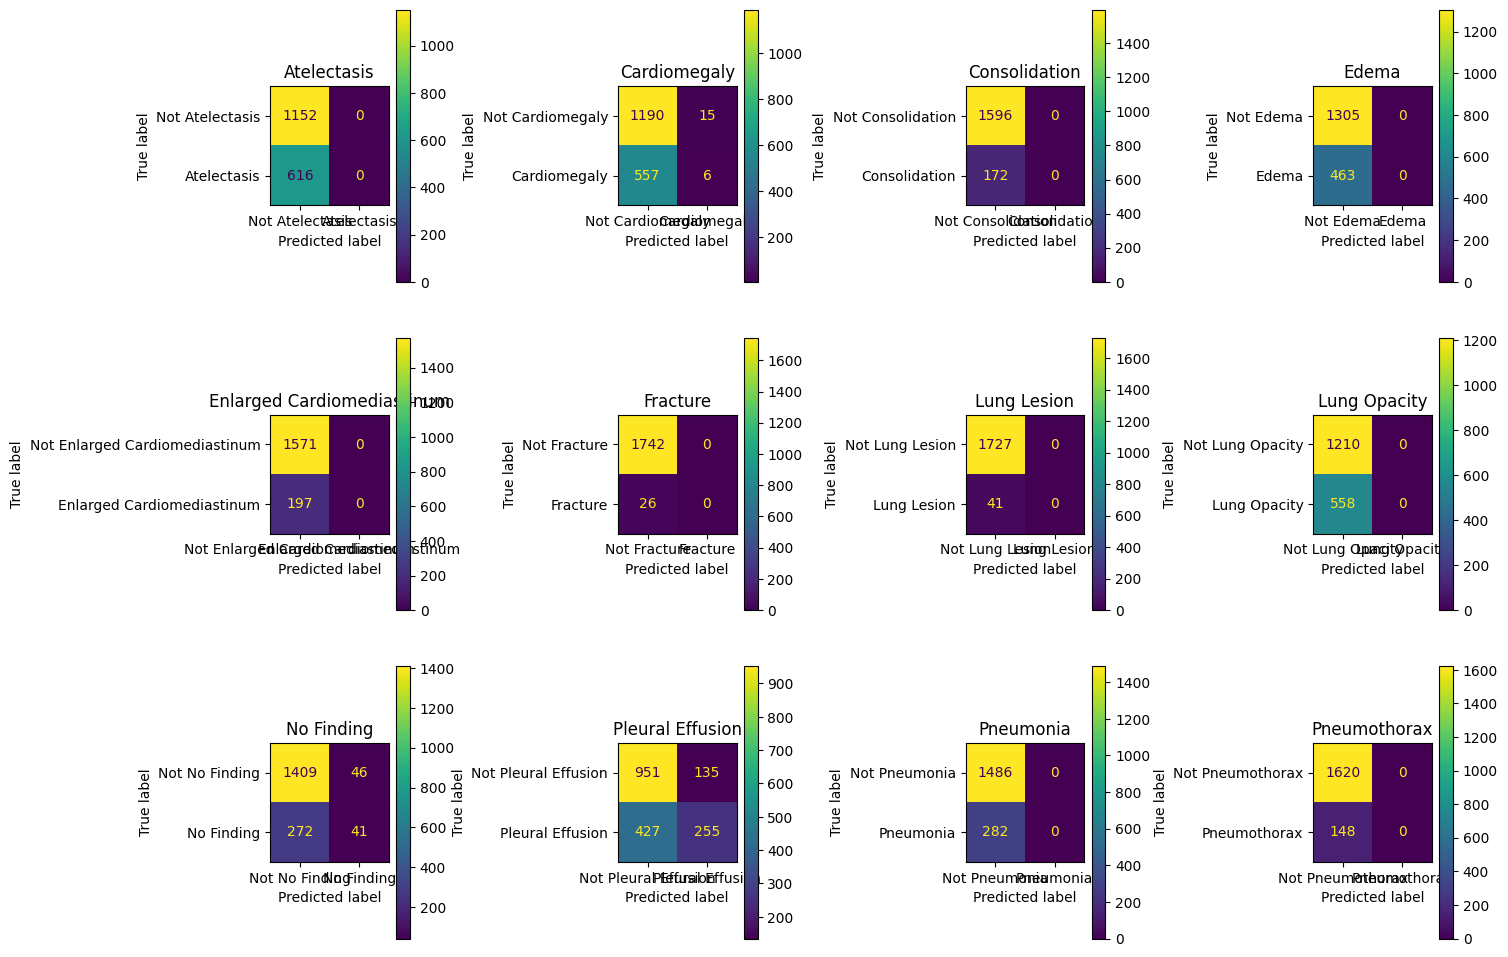

In [ ]:
M_cm = multilabel_confusion_matrix(test_all_labels, test_preds_binary)
fig, axes = plt.subplots(3, 4, figsize=(15, 10))  
axes = axes.ravel()
for i, label in enumerate(unique_labels_small):
    if i < len(axes):  
        display = ConfusionMatrixDisplay(confusion_matrix=M_cm[i], display_labels=[f'Not {label}', label])
        display.plot(ax=axes[i], values_format='d')
        axes[i].set_title(label)
plt.tight_layout()
plt.show()




In [ ]:
print("\nClassification Report (Test Set):")
print(classification_report(test_all_labels, test_preds_binary, target_names=unique_labels_small, zero_division=0))




Classification Report (Test Set):
                            precision    recall  f1-score   support

               Atelectasis       0.00      0.00      0.00       616
              Cardiomegaly       0.29      0.01      0.02       563
             Consolidation       0.00      0.00      0.00       172
                     Edema       0.00      0.00      0.00       463
Enlarged Cardiomediastinum       0.00      0.00      0.00       197
                  Fracture       0.00      0.00      0.00        26
               Lung Lesion       0.00      0.00      0.00        41
              Lung Opacity       0.00      0.00      0.00       558
                No Finding       0.47      0.13      0.20       313
          Pleural Effusion       0.65      0.37      0.48       682
                 Pneumonia       0.00      0.00      0.00       282
              Pneumothorax       0.00      0.00      0.00       148

                 micro avg       0.61      0.07      0.13      4061
           

Loss plot saved to experiment\AlexNet--TL--lr_0.0015--batch_size_48--epochs_5--pytorch\reports\AlexNet--loss_plot.png


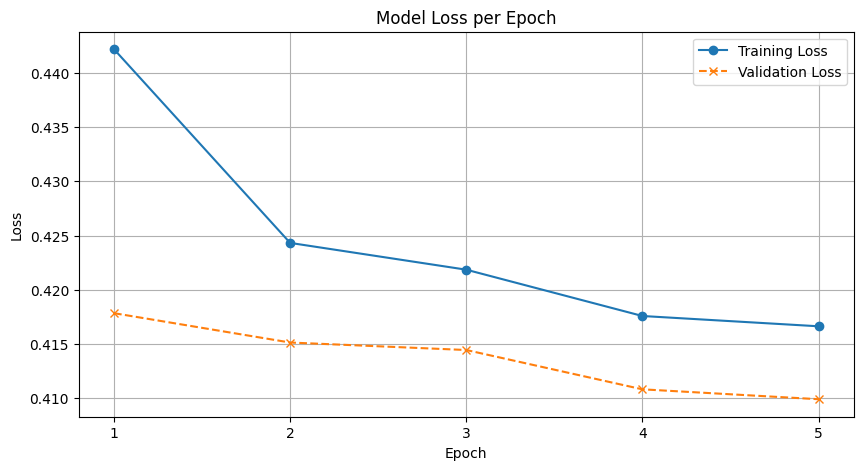

AUC/F1 plot saved to experiment\AlexNet--TL--lr_0.0015--batch_size_48--epochs_5--pytorch\reports\AlexNet--auc_f1_plot.png


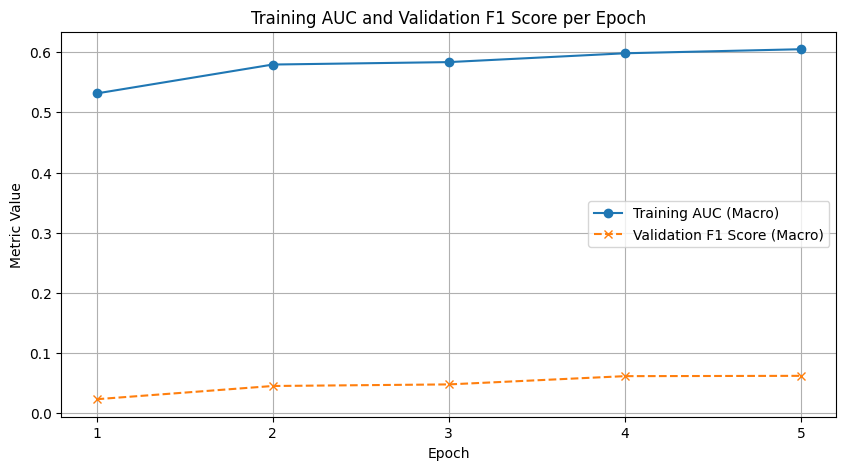

In [ ]:
epochs_completed = len(history['train_loss'])
epochs_range = range(1, epochs_completed + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, history['train_loss'], label='Training Loss', marker='o', linestyle='-')
if 'val_loss' in history and len(history['val_loss']) == epochs_completed:
        plt.plot(epochs_range, history['val_loss'], label='Validation Loss', marker='x', linestyle='--')
else:
    print("Warning: Validation loss data not found or length mismatch, skipping plot.")

plt.title('Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.xticks(epochs_range) 


loss_plot_path = os.path.join(REPORTS_SAVE_PATH, f'{model_name}--loss_plot.png')
plt.savefig(loss_plot_path)
print(f"Loss plot saved to {loss_plot_path}")
plt.show() 



plt.figure(figsize=(10, 5))
plt.plot(epochs_range, history['train_auc'], label='Training AUC (Macro)', marker='o', linestyle='-')
# Check if validation F1 exists before plotting
if 'val_f1' in history and len(history['val_f1']) == epochs_completed:
    plt.plot(epochs_range, history['val_f1'], label='Validation F1 Score (Macro)', marker='x', linestyle='--')
else:
    print("Warning: Validation F1 score data not found or length mismatch, skipping plot.")

plt.title('Training AUC and Validation F1 Score per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')


plt.legend()
plt.grid(True)
plt.xticks(epochs_range)


metrics_plot_path = os.path.join(REPORTS_SAVE_PATH, f'{model_name}--auc_f1_plot.png')
plt.savefig(metrics_plot_path)
print(f"AUC/F1 plot saved to {metrics_plot_path}")
plt.show() 